# Setup

In [2]:
# Add parent directory to current path. Needed for research imports.
import os.path
import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.insert(0,p)

# Enable hot reloading
%load_ext autoreload
%autoreload 2


import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from experiments.irl.fair_irl import *
from research.irl.fair_irl import *
from research.utils import *


logging.basicConfig(level=logging.INFO)
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')

from IPython.display import display, HTML
display(HTML("<style>.container { width:1800px !important; }</style>"))
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_colwidth', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Run experiments

In [3]:
base_exp_info = {
    'OBJECTIVE_NAMES': ['Acc', 'DemPar', 'EqOpp'],
    # Expert demo parameters
    'DATASET': None,
    'TARGET_DATASET': None,
    'N_EXPERT_DEMOS': 3,
    'EXPERT_ALGO': None,
    'N_DATASET_SAMPLES': 25_000,
    # IRL Loop parameters
    'N_TRIALS': 6,
    'IRL_METHOD': None,
    'N_INIT_POLICIES': 1,
    'EPSILON': .03,
    'MAX_ITER': 6,
    'METHOD': 'highs',
    'IRL_ERROR_NORM_WEIGHTS': False,
    # Plotting parameters
    'NOISE_FACTOR': .02,
    'ANNOTATE': True,
}

In [4]:
experiments = [
    {
        'DATASET': 'COMPAS',
        'TARGET_DATASET': 'Adult',
        'EXPERT_ALGO': 'OptAcc',
        'IRL_METHOD': 'FairIRL',
        'N_TRIALS': 2,
    },
    {
        'DATASET': 'COMPAS',
        'TARGET_DATASET': 'Adult',
        'EXPERT_ALGO': 'HardtDemPar',
        'IRL_METHOD': 'FairIRL',
        'N_TRIALS': 2,
    },
    {
        'DATASET': 'COMPAS',
        'TARGET_DATASET': 'Adult',
        'EXPERT_ALGO': 'HardtEqOpp',
        'IRL_METHOD': 'FairIRL',
        'N_TRIALS': 2,
    },
]

In [13]:
for exp_i, experiment in enumerate(experiments):
    logging.info('\n\n')
    logging.info(f"EXPERIMENT {exp_i+1}/{len(experiments)}")
    
    exp_info = dict(base_exp_info)
    
    for k in experiment:
        exp_info[k] = experiment[k]
        
    run_experiment(exp_info)

INFO:root:


INFO:root:EXPERIMENT 1/3
INFO:root:exp_info: {'OBJECTIVE_NAMES': ['Acc', 'DemPar', 'EqOpp'], 'DATASET': 'COMPAS', 'TARGET_DATASET': 'Adult', 'N_EXPERT_DEMOS': 3, 'EXPERT_ALGO': 'OptAcc', 'N_DATASET_SAMPLES': 25000, 'N_TRIALS': 2, 'IRL_METHOD': 'FairIRL', 'N_INIT_POLICIES': 1, 'EPSILON': 0.03, 'MAX_ITER': 6, 'METHOD': 'highs', 'IRL_ERROR_NORM_WEIGHTS': False, 'NOISE_FACTOR': 0.02, 'ANNOTATE': True}
INFO:root:

TRIAL 0

INFO:root:muE:
[[0.62794685 0.7589154  0.80869375]
 [0.65066438 0.77377857 0.79167164]
 [0.62821612 0.79690061 0.83050199]]
INFO:root:muE_hold:
[[0.62210797 0.82557314 0.8496732 ]
 [0.61953728 0.85077166 0.87061404]
 [0.6329331  0.85134324 0.81818879]]
INFO:root:	IRL Loop iteration 1/6 ...
INFO:root:	IRL Loop iteration 2/6 ...
INFO:root:Best Learned Policy yhat: 0.473
INFO:root:best weight:	 [ 0.756 -0.106  0.138]


,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.628,0.759,0.809,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.651,0.774,0.792,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.628,0.797,0.831,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.490,0.996,0.986,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.532,0.002,0.001,0,0.532,0.537,0.537,0.002,0.002,0.002,0.001,0.002,0.002,0.0,1.0,0.280,-0.404,-0.315,0.405,0.433,0.0,0.0
5,0.636,0.689,0.700,0,0.636,0.617,0.617,0.689,0.708,0.708,0.700,0.698,0.698,0.0,2.0,0.756,-0.106,0.138,0.018,0.026,0.0,0.0


INFO:root:muE_target:
[[0.7831094  0.98497758 0.99190119]
 [0.78492559 0.85316784 0.63285109]
 [0.78444551 0.94327541 0.84266929]]
INFO:root:target domain muL = [0.788 0.955 0.924]
INFO:root:target domain muE = [0.784 0.927 0.822]
INFO:root:target domain muL_hold = [0.787 0.959 0.935]
INFO:root:

TRIAL 1

INFO:root:muE:
[[0.63994856 0.78288898 0.77828438]
 [0.63137591 0.76821886 0.78674456]
 [0.61749571 0.78725531 0.78027427]]
INFO:root:muE_hold:
[[0.62810626 0.6853776  0.60105873]
 [0.61268209 0.70781781 0.76282841]
 [0.58919383 0.59782637 0.55700904]]
INFO:root:	IRL Loop iteration 1/6 ...
INFO:root:	IRL Loop iteration 2/6 ...
INFO:root:Best Learned Policy yhat: 0.557
INFO:root:best weight:	 [ 0.868  0.079 -0.053]


,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.640,0.783,0.778,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.631,0.768,0.787,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.617,0.787,0.780,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.503,0.980,0.992,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.531,0.002,0.002,0,0.531,0.539,0.539,0.002,0.002,0.002,0.002,0.003,0.003,0.0,1.0,0.220,-0.371,-0.408,0.430,0.358,0.0,0.0
5,0.633,0.783,0.805,0,0.633,0.609,0.609,0.783,0.768,0.768,0.805,0.810,0.810,0.0,2.0,0.868,0.079,-0.053,0.003,0.012,0.0,0.0


INFO:root:muE_target:
[[0.7903071  0.93503055 0.796174  ]
 [0.78492559 0.93817861 0.83500067]
 [0.79308689 0.92900432 0.80262051]]
INFO:root:target domain muL = [0.791 0.938 0.816]
INFO:root:target domain muE = [0.789 0.934 0.811]
INFO:root:target domain muL_hold = [0.788 0.947 0.883]
INFO:root:


INFO:root:EXPERIMENT 2/3
INFO:root:exp_info: {'OBJECTIVE_NAMES': ['Acc', 'DemPar', 'EqOpp'], 'DATASET': 'COMPAS', 'TARGET_DATASET': 'Adult', 'N_EXPERT_DEMOS': 3, 'EXPERT_ALGO': 'HardtDemPar', 'N_DATASET_SAMPLES': 25000, 'N_TRIALS': 2, 'IRL_METHOD': 'FairIRL', 'N_INIT_POLICIES': 1, 'EPSILON': 0.03, 'MAX_ITER': 6, 'METHOD': 'highs', 'IRL_ERROR_NORM_WEIGHTS': False, 'NOISE_FACTOR': 0.02, 'ANNOTATE': True}
INFO:root:

TRIAL 0

INFO:root:muE:
[[0.58251179 0.9746317  0.97439685]
 [0.59922846 0.98197458 0.94465398]
 [0.59090909 0.99102931 0.9639599 ]]
INFO:root:muE_hold:
[[0.59725793 0.97535888 0.98193898]
 [0.60325621 0.97584092 0.98273233]
 [0.59433962 0.9786839  0.97465549]]
INFO:root:	IRL Loop i

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.583,0.975,0.974,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.599,0.982,0.945,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.591,0.991,0.964,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.508,0.997,0.983,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.606,0.389,0.269,0,0.606,0.601,0.601,0.389,0.387,0.387,0.269,0.278,0.278,0.0,1.0,0.710,-0.210,-0.080,0.137,0.136,0.0,0.0
5,0.626,0.855,0.887,0,0.626,0.612,0.612,0.855,0.813,0.813,0.887,0.840,0.840,0.0,2.0,0.810,-0.042,0.148,0.031,0.025,0.0,0.0
6,0.582,0.811,0.720,0,0.626,0.588,0.612,0.855,0.845,0.813,0.887,0.773,0.840,0.0,3.0,0.501,0.249,0.250,0.041,0.054,0.0,0.0
7,0.553,0.774,0.637,0,0.626,0.546,0.612,0.855,0.797,0.813,0.887,0.667,0.840,0.0,4.0,0.501,0.249,0.250,0.041,0.054,0.0,0.0
8,0.583,0.811,0.721,0,0.626,0.588,0.612,0.855,0.845,0.813,0.887,0.773,0.840,0.0,5.0,0.501,0.249,0.250,0.041,0.054,0.0,0.0
9,0.583,0.811,0.722,0,0.626,0.588,0.612,0.855,0.845,0.813,0.887,0.773,0.840,0.0,6.0,0.501,0.249,0.250,0.041,0.054,0.0,0.0


INFO:root:muE_target:
[[0.7831094  0.98244288 0.84911894]
 [0.76956313 0.99564501 0.87887989]
 [0.77340374 0.97963626 0.93626834]]
INFO:root:target domain muL = [0.785 0.979 0.982]
INFO:root:target domain muE = [0.775 0.986 0.888]
INFO:root:target domain muL_hold = [0.787 0.973 0.974]
INFO:root:

TRIAL 1

INFO:root:muE:
[[0.59922846 0.96568061 0.89655358]
 [0.59108444 0.99467243 0.99935484]
 [0.61106346 0.99831179 0.95380638]]
INFO:root:muE_hold:
[[0.61868038 0.96527451 0.98701681]
 [0.58783205 0.97531803 0.9332844 ]
 [0.60806175 0.9737119  0.99370553]]
INFO:root:	IRL Loop iteration 1/6 ...
INFO:root:	IRL Loop iteration 2/6 ...
INFO:root:	IRL Loop iteration 3/6 ...
INFO:root:	IRL Loop iteration 4/6 ...
INFO:root:	IRL Loop iteration 5/6 ...
INFO:root:	IRL Loop iteration 6/6 ...
INFO:root:Best Learned Policy yhat: 0.529
INFO:root:best weight:	 [0.902 0.037 0.061]


,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.599,0.966,0.897,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.591,0.995,0.999,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.611,0.998,0.954,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.487,0.986,0.977,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.627,0.695,0.700,0,0.627,0.629,0.629,0.695,0.704,0.704,0.700,0.715,0.715,0.0,1.0,0.902,0.037,0.061,0.030,0.028,0.0,0.0
5,0.577,0.791,0.866,0,0.577,0.599,0.599,0.791,0.805,0.805,0.866,0.825,0.825,0.0,2.0,0.613,0.340,-0.047,0.068,0.057,0.0,0.0
6,0.568,0.702,0.794,0,0.577,0.570,0.599,0.791,0.719,0.805,0.866,0.827,0.825,0.0,3.0,0.613,0.340,-0.047,0.068,0.057,0.0,0.0
7,0.568,0.702,0.794,0,0.577,0.570,0.599,0.791,0.719,0.805,0.866,0.827,0.825,0.0,4.0,0.613,0.340,-0.047,0.068,0.057,0.0,0.0
8,0.577,0.791,0.866,0,0.577,0.599,0.599,0.791,0.805,0.805,0.866,0.825,0.825,0.0,5.0,0.613,0.340,-0.047,0.068,0.057,0.0,0.0
9,0.577,0.791,0.866,0,0.577,0.599,0.599,0.791,0.805,0.805,0.866,0.825,0.825,0.0,6.0,0.613,0.340,-0.047,0.068,0.057,0.0,0.0


INFO:root:muE_target:
[[0.77879079 0.9869492  0.9298566 ]
 [0.7806049  0.99918531 0.87688403]
 [0.7681229  0.98344268 0.78747216]]
INFO:root:target domain muL = [0.791 0.856 0.671]
INFO:root:target domain muE = [0.776 0.99  0.865]
INFO:root:target domain muL_hold = [0.786 0.848 0.677]
INFO:root:


INFO:root:EXPERIMENT 3/3
INFO:root:exp_info: {'OBJECTIVE_NAMES': ['Acc', 'DemPar', 'EqOpp'], 'DATASET': 'COMPAS', 'TARGET_DATASET': 'Adult', 'N_EXPERT_DEMOS': 3, 'EXPERT_ALGO': 'HardtEqOpp', 'N_DATASET_SAMPLES': 25000, 'N_TRIALS': 2, 'IRL_METHOD': 'FairIRL', 'N_INIT_POLICIES': 1, 'EPSILON': 0.03, 'MAX_ITER': 6, 'METHOD': 'highs', 'IRL_ERROR_NORM_WEIGHTS': False, 'NOISE_FACTOR': 0.02, 'ANNOTATE': True}
INFO:root:

TRIAL 0

INFO:root:muE:
[[0.58851264 0.99688778 0.94721372]
 [0.5983712  0.89889465 0.96846089]
 [0.6170669  0.90721004 0.94141974]]
INFO:root:muE_hold:
[[0.61096829 0.89710699 0.97994664]
 [0.61096829 0.94012024 0.98766998]
 [0.58233276 0.95586834 0.98163897]]
INFO:root:	IRL Loop it

,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.589,0.997,0.947,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.598,0.899,0.968,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.617,0.907,0.941,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.516,0.994,0.992,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.612,0.394,0.263,0,0.612,0.602,0.602,0.394,0.381,0.381,0.263,0.269,0.269,0.0,1.0,0.614,-0.018,-0.368,0.254,0.263,0.0,0.0
5,0.633,0.759,0.752,0,0.633,0.623,0.623,0.759,0.762,0.762,0.752,0.786,0.786,0.0,2.0,0.869,0.095,0.036,0.033,0.026,0.0,0.0
6,0.554,0.825,0.725,0,0.633,0.566,0.623,0.759,0.819,0.762,0.752,0.723,0.786,0.0,3.0,0.672,0.114,0.214,0.052,0.049,0.0,0.0
7,0.554,0.825,0.725,0,0.633,0.566,0.623,0.759,0.819,0.762,0.752,0.723,0.786,0.0,4.0,0.672,0.114,0.214,0.052,0.049,0.0,0.0
8,0.554,0.825,0.725,0,0.633,0.566,0.623,0.759,0.819,0.762,0.752,0.723,0.786,0.0,5.0,0.672,0.113,0.215,0.052,0.049,0.0,0.0
9,0.554,0.825,0.725,0,0.633,0.566,0.623,0.759,0.819,0.762,0.752,0.723,0.786,0.0,6.0,0.672,0.114,0.214,0.052,0.049,0.0,0.0


INFO:root:muE_target:
[[0.76391555 0.97539692 0.9952176 ]
 [0.77580413 0.97748806 0.99841031]
 [0.78108497 0.97626698 0.98963196]]
INFO:root:target domain muL = [0.774 0.842 0.729]
INFO:root:target domain muE = [0.774 0.976 0.994]
INFO:root:target domain muL_hold = [0.792 0.853 0.687]
INFO:root:

TRIAL 1

INFO:root:muE:
[[0.5932276  0.97296046 0.9734659 ]
 [0.60565795 0.97138376 0.96662933]
 [0.6016295  0.91420911 0.9494664 ]]
INFO:root:muE_hold:
[[0.57155099 0.92101941 0.95535869]
 [0.62810626 0.91330588 0.97442911]
 [0.62349914 0.95963592 0.97891602]]
INFO:root:	IRL Loop iteration 1/6 ...
INFO:root:	IRL Loop iteration 2/6 ...
INFO:root:	IRL Loop iteration 3/6 ...
INFO:root:	IRL Loop iteration 4/6 ...
INFO:root:	IRL Loop iteration 5/6 ...
INFO:root:	IRL Loop iteration 6/6 ...
INFO:root:Best Learned Policy yhat: 0.242
INFO:root:best weight:	 [ 0.699 -0.016  0.285]


,Acc,DemPar,EqOpp,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.593,0.973,0.973,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.606,0.971,0.967,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.602,0.914,0.949,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,inf,inf,0.0,0.0
3,0.494,0.962,0.927,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,inf,inf,0.0,0.0
4,0.569,0.942,0.857,0,0.569,0.558,0.558,0.942,0.937,0.937,0.857,0.812,0.812,0.0,1.0,0.699,-0.016,0.285,0.037,0.057,0.0,0.0
5,0.570,0.951,0.867,0,0.570,0.559,0.559,0.951,0.947,0.947,0.867,0.823,0.823,0.0,2.0,0.404,-0.132,0.464,0.046,0.071,0.0,0.0
6,0.564,0.908,0.815,0,0.570,0.545,0.559,0.951,0.899,0.947,0.867,0.756,0.823,0.0,3.0,0.366,-0.147,0.487,0.048,0.074,0.0,0.0
7,0.564,0.908,0.815,0,0.570,0.545,0.559,0.951,0.899,0.947,0.867,0.756,0.823,0.0,4.0,0.367,-0.146,0.487,0.048,0.074,0.0,0.0
8,0.564,0.908,0.815,0,0.570,0.545,0.559,0.951,0.899,0.947,0.867,0.756,0.823,0.0,5.0,0.367,-0.146,0.487,0.048,0.074,0.0,0.0
9,0.564,0.783,0.662,0,0.570,0.547,0.559,0.951,0.780,0.947,0.867,0.612,0.823,0.0,6.0,0.367,-0.146,0.487,0.048,0.074,0.0,0.0


INFO:root:muE_target:
[[0.77975048 0.97240995 0.95848291]
 [0.79020643 0.97266934 0.96556416]
 [0.77628421 0.97878793 0.94065934]]
INFO:root:target domain muL = [0.767 0.98  0.879]
INFO:root:target domain muE = [0.782 0.975 0.955]
INFO:root:target domain muL_hold = [0.767 0.999 0.973]


# Compare results with source domain only

In [14]:
!rm ../../data/experiment_output/fair_irl/exp_info/.DS_Store
!rm ../../data/experiment_output/fair_irl/exp_results/.DS_Store

rm: ../../data/experiment_output/fair_irl/exp_info/.DS_Store: No such file or directory
rm: ../../data/experiment_output/fair_irl/exp_results/.DS_Store: No such file or directory


In [15]:
min_exp_timestamp = '2023-06-06 00:00:00'

def skip_irl_error_norm_true(info):
    return 'IRL_ERROR_NORM_WEIGHTS' in info and info['IRL_ERROR_NORM_WEIGHTS'] == True

def skip_irl_error_norm_false(info):
    return 'IRL_ERROR_NORM_WEIGHTS' not in info or (
        'IRL_ERROR_NORM_WEIGHTS' in info and info['IRL_ERROR_NORM_WEIGHTS'] == False
    )

DATASET: COMPAS


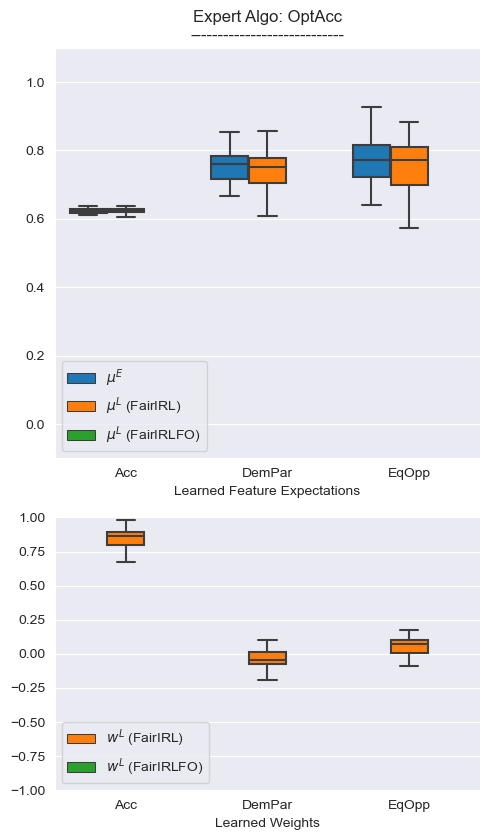

In [16]:
n_expert_demos = 3
n_init_pols = 1

mu_df, w_df = plot_results_source_domain_only(
    objective_set_names=['Acc', 'DemPar', 'EqOpp'],
    expert_algo='OptAcc',
    dataset='COMPAS',
    mu_noise_factor=.01,
    w_noise_factor=.01,
    mu_hue_order=['muE', 'muL (FairIRL)', 'muL (FairIRLFO)'],
    w_hue_order=[None, 'wL (FairIRL)', 'wL (FairIRLFO)'],
#     extra_skip_conditions=(lambda info: (info['N_EXPERT_DEMOS'] != n_expert_demos) or (info['N_INIT_POLICIES'] != n_init_pols)),
    extra_skip_conditions=skip_irl_error_norm_true,
    min_exp_timestamp=min_exp_timestamp,
)

DATASET: COMPAS


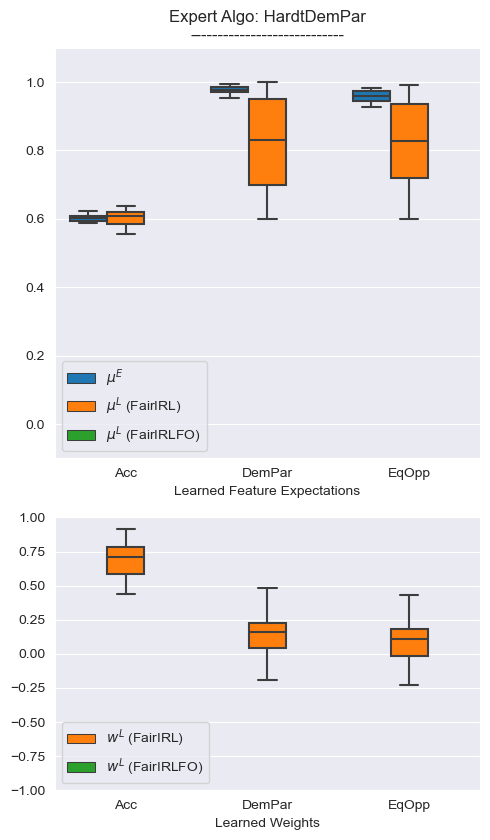

In [17]:
n_expert_demos = 3
n_init_pols = 1

mu_df, w_df = plot_results_source_domain_only(
    objective_set_names=['Acc', 'DemPar', 'EqOpp'],
    expert_algo='HardtDemPar',
    dataset='COMPAS',
    mu_noise_factor=.01,
    w_noise_factor=.01,
    mu_hue_order=['muE', 'muL (FairIRL)', 'muL (FairIRLFO)'],
    w_hue_order=[None, 'wL (FairIRL)', 'wL (FairIRLFO)'],
#     extra_skip_conditions=(lambda info: (info['N_EXPERT_DEMOS'] != n_expert_demos) or (info['N_INIT_POLICIES'] != n_init_pols)),
    extra_skip_conditions=skip_irl_error_norm_true,
    min_exp_timestamp=min_exp_timestamp,
)

DATASET: COMPAS


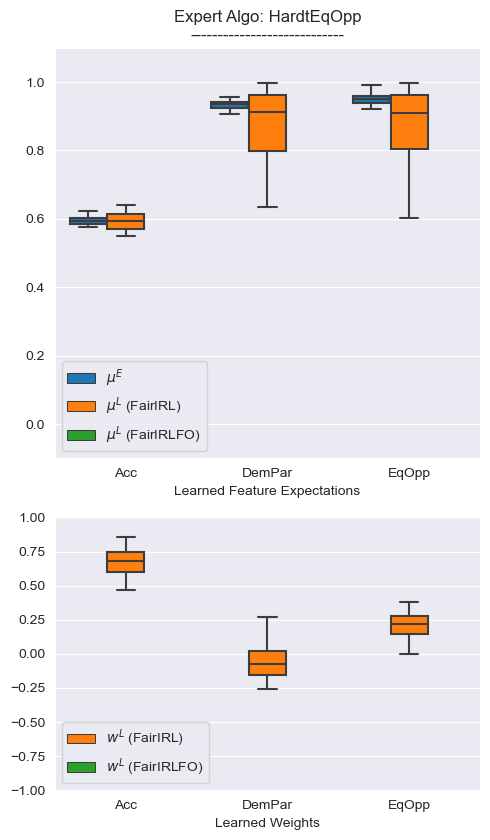

In [18]:
n_expert_demos = 3
n_init_pols = 1

mu_df, w_df = plot_results_source_domain_only(
    objective_set_names=['Acc', 'DemPar', 'EqOpp'],
    expert_algo='HardtEqOpp',
    dataset='COMPAS',
    mu_noise_factor=.01,
    w_noise_factor=.01,
    mu_hue_order=['muE', 'muL (FairIRL)', 'muL (FairIRLFO)'],
    w_hue_order=[None, 'wL (FairIRL)', 'wL (FairIRLFO)'],
#     extra_skip_conditions=(lambda info: (info['N_EXPERT_DEMOS'] != n_expert_demos) or (info['N_INIT_POLICIES'] != n_init_pols)),
    extra_skip_conditions=skip_irl_error_norm_false,
    min_exp_timestamp=min_exp_timestamp,
)

# Compare results with target domain

SOURCE DATASET: COMPAS
TARGET DATASET: Adult


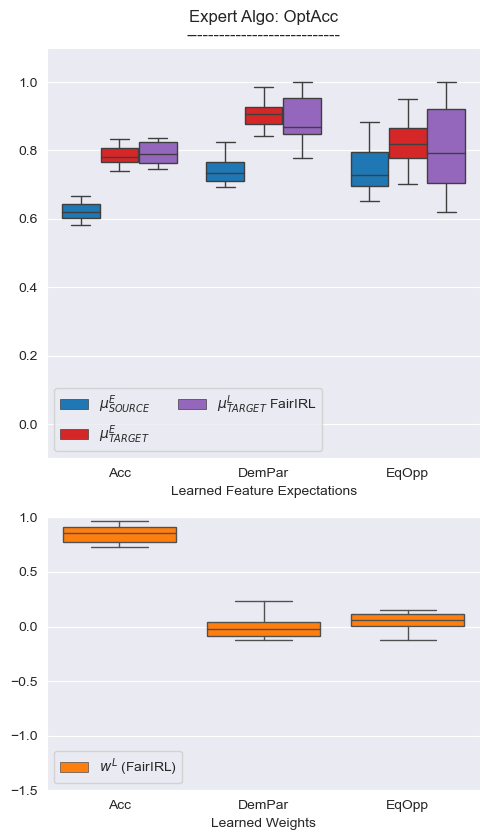

In [19]:
mu_df, w_df = plot_results_target_domain(
    objective_set_names=['Acc', 'DemPar', 'EqOpp'],
    expert_algo='OptAcc',
    source_dataset='COMPAS',
    target_dataset='Adult',
    mu_noise_factor=.1,
    w_noise_factor=.01,
    extra_skip_conditions=skip_irl_error_norm_false,
    min_exp_timestamp=min_exp_timestamp,
)

SOURCE DATASET: COMPAS
TARGET DATASET: Adult


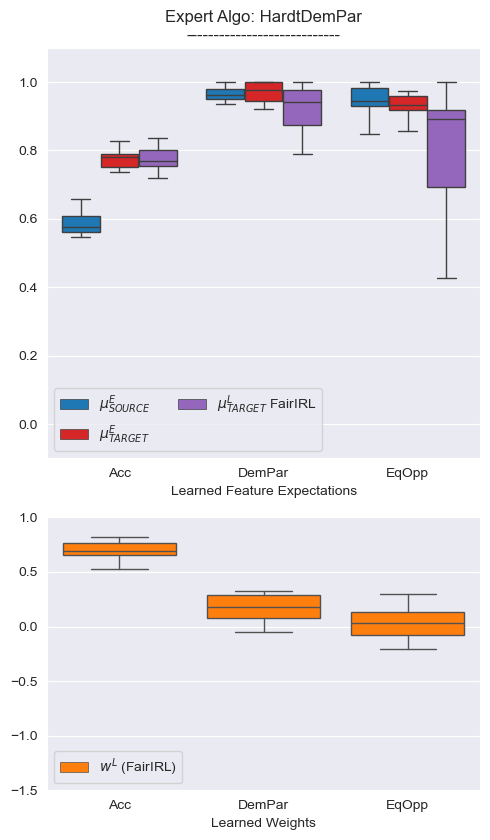

In [20]:
mu_df, w_df = plot_results_target_domain(
    objective_set_names=['Acc', 'DemPar', 'EqOpp'],
    expert_algo='HardtDemPar',
    source_dataset='COMPAS',
    target_dataset='Adult',
    mu_noise_factor=.1,
    w_noise_factor=.01,
    extra_skip_conditions=skip_irl_error_norm_false,
    min_exp_timestamp=min_exp_timestamp,
)

SOURCE DATASET: COMPAS
TARGET DATASET: Adult


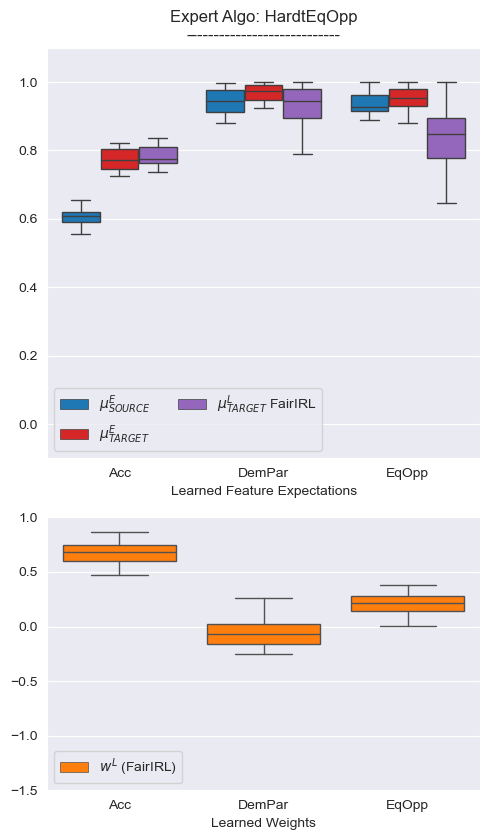

In [21]:
mu_df, w_df = plot_results_target_domain(
    objective_set_names=['Acc', 'DemPar', 'EqOpp'],
    expert_algo='HardtEqOpp',
    source_dataset='COMPAS',
    target_dataset='Adult',
    mu_noise_factor=.1,
    w_noise_factor=.01,
    extra_skip_conditions=skip_irl_error_norm_false,
    min_exp_timestamp=min_exp_timestamp,
)

# Scratch